/var/tmp/ipykernel_2049108/331226189.py:28: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("/home/jedrzej/projects/image_flow_cytometry_fine_tune/data/jedrzej/metadata_subset.csv.gz")
100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


statistics used: {'min': tensor([0., 0., 0., 0., 0.]), 'p01': tensor([0., 0., 0., 0., 0.]), 'p05': tensor([0., 0., 0., 0., 0.]), 'p25': tensor([0.1873, 0.0110, 0.0093, 0.0137, 0.0095]), 'p50': tensor([0.1876, 0.0155, 0.0154, 0.0169, 0.0095]), 'p75': tensor([0.1876, 0.0179, 0.0198, 0.0217, 0.0096]), 'p95': tensor([0.1883, 0.0223, 0.0230, 0.0244, 0.0098]), 'p99': tensor([0.1939, 0.0381, 0.0469, 0.0422, 0.0100]), 'max': tensor([0.2750, 0.3751, 0.1919, 0.1289, 0.0386]), 'mean': tensor([0.1634, 0.0142, 0.0150, 0.0167, 0.0083]), 'std': tensor([0.0630, 0.0089, 0.0093, 0.0085, 0.0032])}


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized because the shapes did not match:
- embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 5, 16, 16]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


> Initializing models...
trainable params: 294,912 || all params: 86,493,705 || trainable%: 0.3410
None


/home/jedrzej/projects/image_flow_cytometry_fine_tune/.venv/lib/python3.10/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.lo

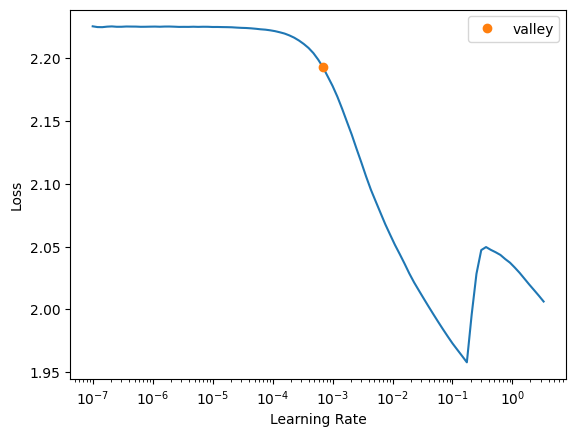

In [ ]:
# %%
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.utils import get_statistics
from torch.utils.data import DataLoader
import os
import random
import sys
from pathlib import Path
sys.path.append(str(Path('../../').resolve()))
from utils import vit_lora
from fastai.vision.all import *

# %%

seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

# %%
metadata = pd.read_csv("/home/jedrzej/projects/image_flow_cytometry_fine_tune/data/jedrzej/metadata_subset.csv.gz")
metadata

# %%
metadata.set.unique()

# %%
indx = metadata.condition.isin(["-SEA","+SEA"])
metadata = metadata.loc[indx, :].reset_index(drop = True )

# %%
set_of_interesting_classes = ['B_cell',  'T_cell', 
                        'T_cell_with_signaling',
                        'T_cell_with_B_cell_fragments',
                        'B_T_cell_in_one_layer',
                        'Synapses_without_signaling', 
                        'Synapses_with_signaling',
                        'No_cell_cell_interaction', 
                        'Multiplets'] 

indx = metadata.set.isin([ "train", "validation","test" ])
indx = indx & metadata.label.isin(set_of_interesting_classes)

train_index = metadata["set"] == "train"
train_index = train_index & metadata.label.isin(set_of_interesting_classes)
train_index = train_index[train_index].index

validation_index = metadata["set"] == "validation"
validation_index = validation_index & metadata.label.isin(set_of_interesting_classes)
validation_index = validation_index[validation_index].index

test_index = metadata["set"] == "test"
test_index = test_index & metadata.label.isin(set_of_interesting_classes)
test_index = test_index[test_index].index

# %%
metadata["set"].unique()

# %%
label_map = dict()
for i, cl in enumerate(set_of_interesting_classes):
    label_map[cl] = i

label_map['-1'] = -1
label_map[-1] = -1


# %%
label_map

# %%
channels = {
     "Ch1": ("Greys", "BF"),  
     "Ch2": ("Greens", "Antibody"),
     "Ch3": ("Reds", "CD18"),
     "Ch4": ("Oranges", "F-Actin"),
     "Ch6": ("RdPu", "MHCII"),
     "Ch7": ("Purples", "CD3/CD4"),
     "Ch11": ("Blues", "P-CD3zeta"),
     "Ch12": ("Greens", "Live-Dead")
 }

# %%
selected_channels = [0,3,4,5,6]
model_dir = "models"
log_dir = "logs"
scaling_factor = 4095.
reshape_size = 224
train_transform = [
         transforms.RandomVerticalFlip(),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(45)
        ]
test_transform = [ ]

# %%
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose(train_transform))

# %%
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=1)


# %%
statistics = get_statistics(train_loader, selected_channels=selected_channels)


# %%
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# %%
class MinMaxScaler(object):
    def __init__(self, min_in , max_in, min_out, max_out):
        self.min_in = min_in.reshape(-1,1,1)
        self.max_in = max_in.reshape(-1,1,1)
        self.min_out = min_out
        self.max_out = max_out
        
    def __call__(self, tensor):
        
        tensor_ = (tensor - self.min_in)/(self.max_in - self.min_in)
        tensor_ = tensor_*(self.max_out - self.min_out) + self.min_out
        tensor_[tensor_<self.min_out]= self.min_out
        tensor_[tensor_>self.max_out]= self.max_out
        return tensor_
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_out={0}, max_out={1})'.format(self.min_out, self.max_out)

class ModelOutputWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, *args, **kwargs):
        outputs = self.model(*args, **kwargs)
        return outputs.logits  # return only logits for FastAI compatibility

# %%
train_transform = transforms.Compose([ 
        MinMaxScaler(           min_in =  statistics["p05"] , 
                                max_in =  statistics["p95"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.RandomResizedCrop(reshape_size, scale=(0.6, 1.0), ratio=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AddGaussianNoise(mean=0., std=0.01),
])

validation_transform =  transforms.Compose([ 
        MinMaxScaler(           min_in =  statistics["p05"] , 
                                max_in =  statistics["p95"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AddGaussianNoise(mean=0., std=0.01),
])

test_transform =  transforms.Compose([ 
        MinMaxScaler(           min_in =  statistics["p05"] , 
                                max_in =  statistics["p95"] , 
                                min_out =  0. , 
                                max_out =  1.),
])


# %%
lr=0.0004
batch_size=32
max_epochs=1
lora_r_alpha = 8
lora_target_modules = [    
    "attention.query",  # Query layer in attention
    "attention.value",  # Value layer in attention
]
lora_bias = "none"
lora_dropout = 0.1

# %%
from fastai.vision.all import *
from torch.utils.data import DataLoader

train_dataset = DatasetGenerator(metadata=metadata.loc[train_index, :],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=train_transform)

valid_dataset = DatasetGenerator(metadata=metadata.loc[validation_index, :],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=validation_transform)

# Convert to FastAI DataLoaders
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
dls = DataLoaders(train_dl, valid_dl)

# %%
# model = convnext.ConvnextModel(num_classes=len(set_of_interesting_classes), in_chans=len(selected_channels))
model = vit_lora.VitModel(num_classes=len(set_of_interesting_classes), in_chans=len(selected_channels), steps_per_epoch=len(train_dl), learning_rate=lr, max_epochs=max_epochs,
                          lora_r_alpha=lora_r_alpha, lora_target_modules=lora_target_modules, lora_dropout=lora_dropout, lora_bias=lora_bias)
wrapped_model = ModelOutputWrapper(model)
# %%
torch.cuda.empty_cache()
learn = Learner(dls, wrapped_model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, F1Score()])
lr_finder = learn.lr_find(show_plot=True)